Converting generated SMILES to molecules...
Converting enumerated SMILES to molecules...
Generating fingerprints...
Number of generated fingerprints after sampling: 15
Number of enumerated fingerprints after sampling: 15
Calculating similarity matrix...

Similarity Statistics (FingerprintGenerator64):
Average similarity: 0.168
Maximum similarity: 0.474
Minimum similarity: 0.042

--- Displaying Top 5 Most Similar Pairs Individually (Original on Left) ---

Top Pair Rank 1 (Similarity: 0.474)


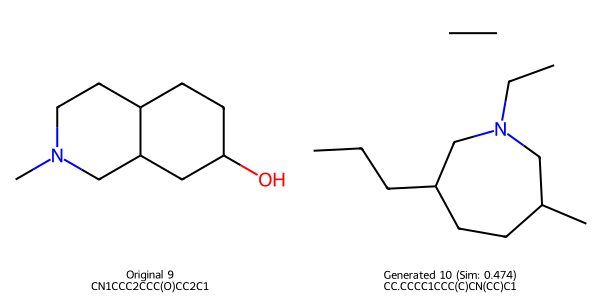


Top Pair Rank 2 (Similarity: 0.440)


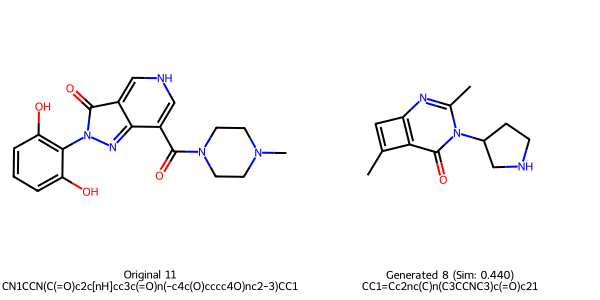


Top Pair Rank 3 (Similarity: 0.438)


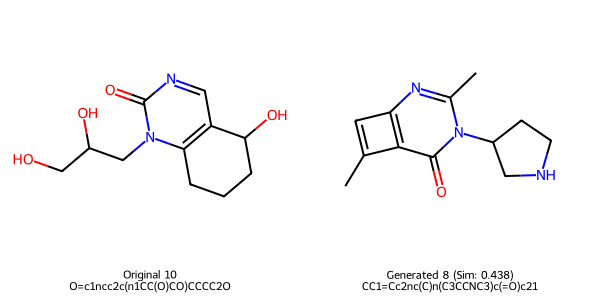


Top Pair Rank 4 (Similarity: 0.420)


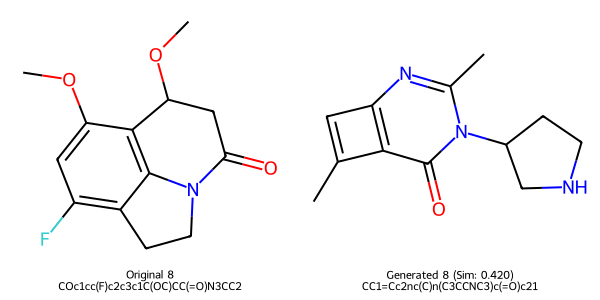


Top Pair Rank 5 (Similarity: 0.368)


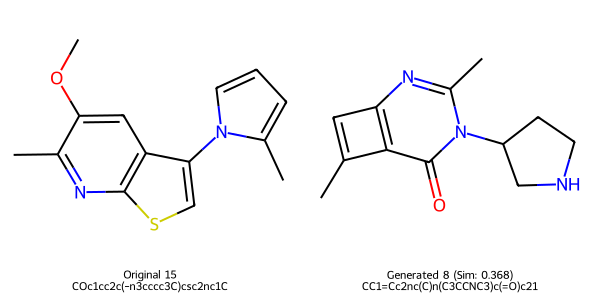


--- Selecting and Visualizing 5 Random Pairs (Original on Left) ---
Displaying 5 randomly selected pairs individually:

Random Pair 1/5 (Orig Index 2, Gen Index 13, Sim: 0.171)


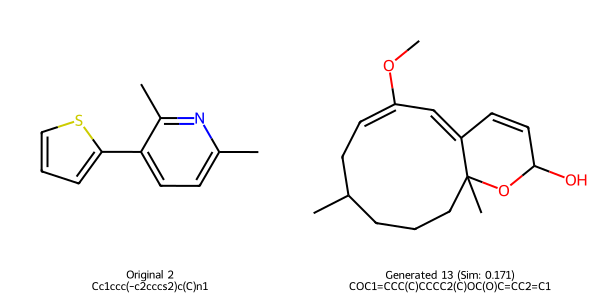


Random Pair 2/5 (Orig Index 15, Gen Index 13, Sim: 0.241)


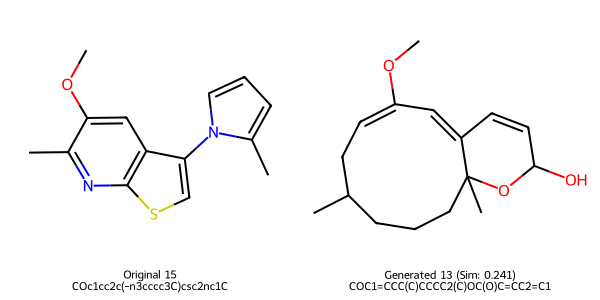


Random Pair 3/5 (Orig Index 3, Gen Index 11, Sim: 0.163)


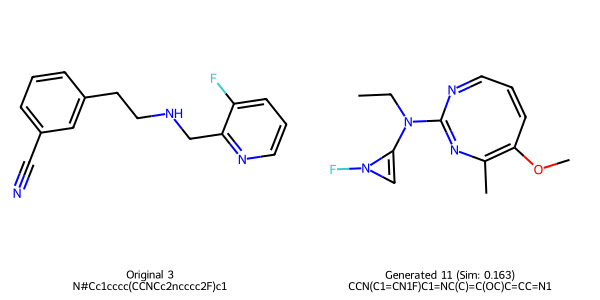


Random Pair 4/5 (Orig Index 11, Gen Index 11, Sim: 0.272)


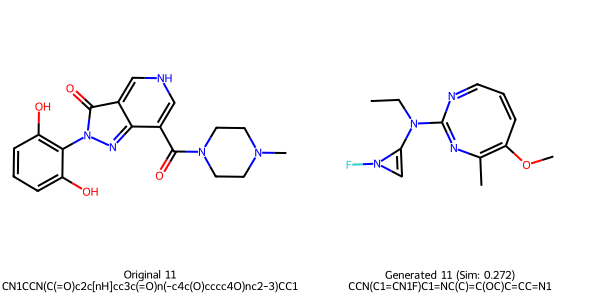


Random Pair 5/5 (Orig Index 3, Gen Index 8, Sim: 0.191)


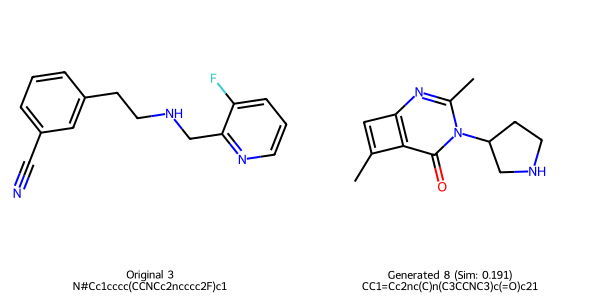


--- Preparing Data for CSV: All 225 Random Sample Comparisons ---

--- Saving ALL 225 Pairs Data to CSV ---
Successfully saved data for all pairs to all_random_pairs_similarity_data.csv

--- Generating Heatmap ---


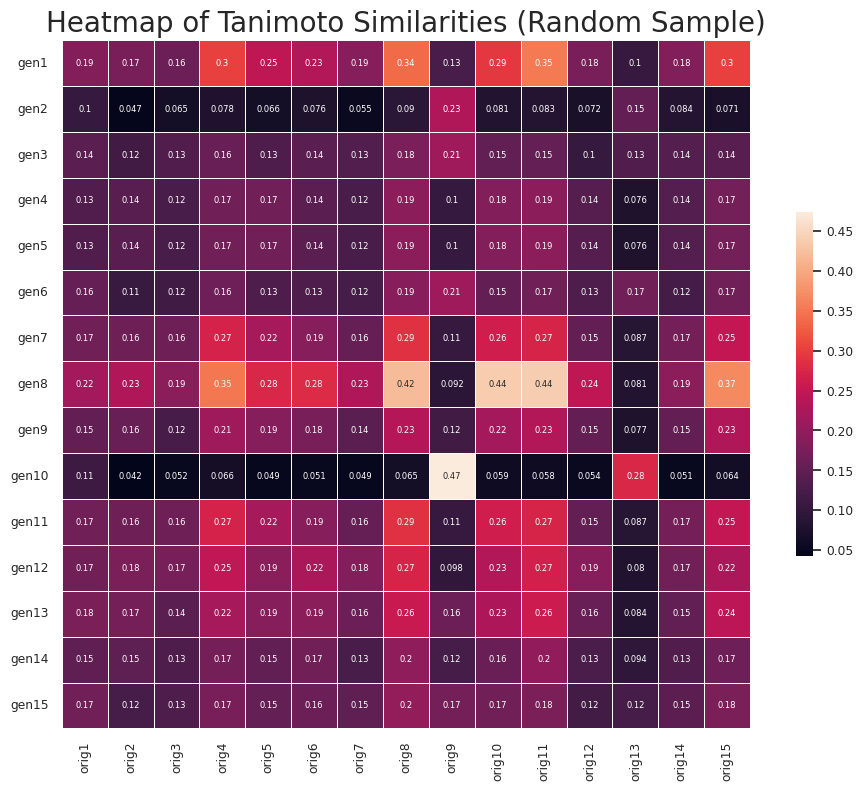

In [13]:
!pip install rdkit-pypi numpy Pillow pandas seaborn matplotlib tqdm

import sys
from pathlib import Path
import seaborn as sns
import pandas as pd
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator

# Load the data (same as before)
generated_df = pd.read_csv("generated_molecules.csv")
enumerated_df = pd.read_csv("enumerated_smiles.csv")


n_samples = 15
num_gen_rows = len(generated_df)
num_enum_rows = len(enumerated_df)

actual_gen_samples = min(n_samples, num_gen_rows)
actual_enum_samples = min(n_samples, num_enum_rows)

generated_smiles_series = generated_df['SMILES'].sample(n=actual_gen_samples, replace=False)
enumerated_smiles_series = enumerated_df['Enumerated_SMILES'].sample(n=actual_enum_samples, replace=False)

# Convert the sampled pandas Series to lists (same as before)
generated_smiles = generated_smiles_series.tolist()
enumerated_smiles = enumerated_smiles_series.tolist()

generated_mols = []
generated_valid_smiles = []
enumerated_mols = []
enumerated_valid_smiles = []

print("Converting generated SMILES to molecules...")
count_gen_valid = 0
count_gen_invalid = 0
for smiles in generated_smiles:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        generated_mols.append(mol)
        generated_valid_smiles.append(smiles)
        count_gen_valid += 1
    else:
        count_gen_invalid += 1
if count_gen_invalid > 0:
    print(f"  Warning: {count_gen_invalid} invalid generated SMILES skipped.")

print("Converting enumerated SMILES to molecules...")
count_enum_valid = 0
count_enum_invalid = 0
for smiles in enumerated_smiles:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        enumerated_mols.append(mol)
        enumerated_valid_smiles.append(smiles)
        count_enum_valid += 1
    else:
        count_enum_invalid += 1
if count_enum_invalid > 0:
    print(f"  Warning: {count_enum_invalid} invalid enumerated SMILES skipped.")



# Fingerprint generation
fp_generator = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=7)
print("Generating fingerprints...")
generated_fps = [fp_generator.GetFingerprint(mol) for mol in generated_mols]
enumerated_fps = [fp_generator.GetFingerprint(mol) for mol in enumerated_mols]

# Calculate number of fingerprints
num_gen = len(generated_fps)
num_enum = len(enumerated_fps)
if num_gen == 0 or num_enum == 0:
    print("Error: No valid molecules found in one or both input sets after parsing. Cannot calculate similarities.")
    sys.exit()
print(f"Number of generated fingerprints after sampling: {num_gen}")
print(f"Number of enumerated fingerprints after sampling: {num_enum}")

# Calculate similarity matrix
print("Calculating similarity matrix...")
similarities = np.zeros((num_gen, num_enum))
for i in range(num_gen):
    similarities[i,:] = DataStructs.BulkTanimotoSimilarity(generated_fps[i], enumerated_fps)


# Heatmap function definition
def normal_heatmap(sim_matrix):
    output_suffix = "random_sample"
    try:
        np.savetxt(f"similarities_{output_suffix}.txt", sim_matrix)
    except Exception as e:
        print(f"Error saving similarities text file: {e}")


    plt.figure(figsize=(10, 8))
    sns.set(font_scale=0.8)


    # Adjust labels if needed, especially if sample size is less than 15
    xticklabels=[f'orig{i+1}' for i in range(sim_matrix.shape[1])]
    yticklabels=[f'gen{i+1}' for i in range(sim_matrix.shape[0])]


    plot = sns.heatmap(sim_matrix,
                       annot=True,
                       annot_kws={"fontsize": 6},
                       square=True,
                       xticklabels=xticklabels,
                       yticklabels=yticklabels,
                       linewidths=.7,
                       cbar_kws={"shrink": .5})


    plt.title(f'Heatmap of Tanimoto Similarities (Random Sample)', fontsize=20)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()


    try:
        plt.savefig(f"tanimoto_heatmap_{output_suffix}_0_1_scale.png")
        plt.show()
    except Exception as e:
         print(f"Error saving or showing heatmap: {e}")


# --- Statistics ---
print(f"\nSimilarity Statistics ({fp_generator.__class__.__name__}):")
print(f"Average similarity: {np.mean(similarities):.3f}")
print(f"Maximum similarity: {np.max(similarities):.3f}")
print(f"Minimum similarity: {np.min(similarities):.3f}")


# --- Overall Check ---
if not (similarities.size > 0 and num_gen > 0 and num_enum > 0):
    if similarities.size == 0:
         print("\nSimilarity matrix is empty. Cannot generate comparisons.")
    else:
         print("\nNot enough molecules in one or both sets after parsing to generate comparisons.")


n_top = 5
num_elements = similarities.size
k = min(n_top, num_elements) # Determine how many top pairs we can actually get

if k > 0:
    # Get indices of top k pairs (highest similarity)
    flat_indices = np.argsort(similarities.flatten())[-k:]
    row_indices, col_indices = np.unravel_index(flat_indices, similarities.shape)

    print(f"\n--- Displaying Top {k} Most Similar Pairs Individually (Original on Left) ---")

    # Iterate top k pairs for visualization data (most similar first)
    for i in range(k - 1, -1, -1):
        r = row_indices[i]
        c = col_indices[i]
        sim_score = similarities[r, c]

        # Wrap individual pair processing in try-except
        try:
            # Check indices before accessing lists
            if r >= len(generated_mols) or r >= len(generated_valid_smiles):
                 print(f"\nError: Generated index {r} out of bounds for Top Pair Rank {k-i}. Skipping.")
                 continue
            if c >= len(enumerated_mols) or c >= len(enumerated_valid_smiles):
                 print(f"\nError: Original index {c} out of bounds for Top Pair Rank {k-i}. Skipping.")
                 continue

            # Retrieve molecules and SMILES
            gen_mol = generated_mols[r]
            orig_mol = enumerated_mols[c]
            gen_smiles_display = generated_valid_smiles[r]
            orig_smiles_display = enumerated_valid_smiles[c]

            # Print only the Rank/Similarity info line
            print(f"\nTop Pair Rank {k-i} (Similarity: {sim_score:.3f})")


            # Prepare data for visualization
            mols_for_individual_top_pair = [orig_mol, gen_mol]
            legends_for_individual_top_pair = [
                f"Original {c+1}\n{orig_smiles_display}",
                f"Generated {r+1} (Sim: {sim_score:.3f})\n{gen_smiles_display}"
            ]

            # Create and display the image for THIS SINGLE top pair
            img_top_pair = Draw.MolsToGridImage(
                mols_for_individual_top_pair,
                molsPerRow=2,
                subImgSize=(300, 300),
                legends=legends_for_individual_top_pair
            )
            # Display this individual top pair image inline
            display(img_top_pair)

        except Exception as e:
             print(f"\nError processing or displaying Top Pair Rank {k-i} ({r},{c}): {e}")

else: # This 'else' corresponds to 'if k > 0'
    print("\nNot enough similarity values to find top pairs for visualization.")

# --- Part 2: Visualize 5 Random Pairs (Orig on Left) ---
print("\n--- Selecting and Visualizing 5 Random Pairs (Original on Left) ---")
total_pairs = num_gen * num_enum
n_random_pairs = min(5, total_pairs) # Select up to 5 random pairs

if n_random_pairs > 0:
    # Create a list of all possible (row, col) index pairs
    all_indices = [(r, c) for r in range(num_gen) for c in range(num_enum)]

    # Randomly sample without replacement
    random_indices_to_display = random.sample(all_indices, n_random_pairs)

    print(f"Displaying {n_random_pairs} randomly selected pairs individually:")
    for i, (r, c) in enumerate(random_indices_to_display):
        try:
            sim_score = similarities[r, c]
            # Index checks
            if r >= len(generated_mols) or r >= len(generated_valid_smiles):
                 print(f"\nError: Generated index {r} out of bounds for Random Pair {i+1}. Skipping.")
                 continue
            if c >= len(enumerated_mols) or c >= len(enumerated_valid_smiles):
                 print(f"\nError: Original index {c} out of bounds for Random Pair {i+1}. Skipping.")
                 continue

            # Retrieve molecules and SMILES
            gen_mol = generated_mols[r]
            orig_mol = enumerated_mols[c]
            gen_smiles_display = generated_valid_smiles[r]
            orig_smiles_display = enumerated_valid_smiles[c]

            # Print condensed info line (already doesn't show SMILES separately)
            print(f"\nRandom Pair {i+1}/{n_random_pairs} (Orig Index {c+1}, Gen Index {r+1}, Sim: {sim_score:.3f})") # Adjusted indices in printout

            # Prepare data for visualization - SWAPPED ORDER
            mols_for_random_pair = [orig_mol, gen_mol] # Swapped
            legends_for_random_pair = [
                f"Original {c+1}\n{orig_smiles_display}", # Swapped
                f"Generated {r+1} (Sim: {sim_score:.3f})\n{gen_smiles_display}" # Swapped
            ]

            # Create and display the image for this single random pair
            img_random_pair = Draw.MolsToGridImage(
                mols_for_random_pair,
                molsPerRow=2,
                subImgSize=(300, 300),
                legends=legends_for_random_pair
            )
            display(img_random_pair) # Display this random pair

        except Exception as e:
            print(f"\nError processing or displaying random pair {i+1} ({r},{c}): {e}")
else:
    print("No pairs available to select random samples from.")



#Generate CSV for ALL Pairs --
print(f"\n--- Preparing Data for CSV: All {num_gen * num_enum} Random Sample Comparisons ---")
all_pairs_data_for_csv = []
for r in range(num_gen):
    for c in range(num_enum):
        if r >= len(generated_valid_smiles) or c >= len(enumerated_valid_smiles):
            print(f"Warning: Skipping pair ({r}, {c}) for CSV due to index mismatch.")
            continue
        sim_score = similarities[r, c]
        gen_smiles_display = generated_valid_smiles[r]
        orig_smiles_display = enumerated_valid_smiles[c]
        pair_info_csv = {
            'Generated_Index': r + 1, 'Generated_SMILES': gen_smiles_display,
            'Original_Index': c + 1, 'Original_SMILES': orig_smiles_display,
            'Tanimoto_Similarity': round(sim_score, 4)
        }
        all_pairs_data_for_csv.append(pair_info_csv)

if all_pairs_data_for_csv:
    print(f"\n--- Saving ALL {len(all_pairs_data_for_csv)} Pairs Data to CSV ---")
    try:
        all_pairs_df = pd.DataFrame(all_pairs_data_for_csv)
        csv_filename_all = "all_random_pairs_similarity_data.csv"
        all_pairs_df.to_csv(csv_filename_all, index=False)
        print(f"Successfully saved data for all pairs to {csv_filename_all}")
    except Exception as e:
        print(f"Error saving all pairs data to CSV: {e}")
else:
     print("\nNo data collected for CSV.")


#Generate Heatmap
if similarities.size > 0:
    print("\n--- Generating Heatmap ---") # Added print statement
    if 'normal_heatmap' in locals() or 'normal_heatmap' in globals():
        normal_heatmap(similarities)
    else:
        print("Warning: normal_heatmap function not defined.")